# **PART I: ENCODING IMAGES INTO LATENT VECTOR SPACE**


---
### Before you move on, make sure you have GPU acceleration enabled:
*    Click 'Runtime' in the menu tab at the top
*    Click 'Change runtime type'
*    Make sure the hardware accelerator is set to 'GPU'

### To run a cell just press Ctrl + Enter
### Let's first clone the Github repo we'll use: https://github.com/pbaylies/stylegan-encoder


In [0]:
!rm -rf sample_data
!git clone  https://github.com/pbaylies/stylegan-encoder

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 453, done.
remote: Total 453 (delta 0), reused 0 (delta 0), pack-reused 453
Receiving objects: 100% (453/453), 12.61 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (257/257), done.


### Run the following cell to mount this to your drive(Save As Directory)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### **Change your directory to the cloned-repo folder (only run this cell once or things might get buggy)**

In [0]:
cd stylegan-encoder

/content/stylegan-encoder


### This is just to list out contents of your current directory

In [0]:
ls

align_images.py                        Play_with_latent_directions.ipynb
config.py*                             pretrained_example.py*
dataset_tool.py*                       README.md*
dnnlib/                                requirements.txt
encode_images.py                       run_metrics.py*
encoder/                               StyleGAN_Encoder_Tutorial.ipynb
ffhq_dataset/                          swa.py
generate_figures.py*                   teaser.png
Learn_direction_in_latent_space.ipynb  train_effnet.py
LICENSE.txt*                           training/
metrics/                               train.py*
mona_example.jpg                       train_resnet.py


### **Setting up folder structure for our images**

In [0]:
rm -rf aligned_images raw_images

In [0]:
mkdir aligned_images raw_images

# Get Images:

## Tips for images:
*   Use HD Images(about 1000x1000 resolution)
*   Make Sure face isn't too small
*   Frotn facing and neutral expression images are preffered
*   Clear, Uniform lighting conditions are also recommended

## Uploading the images:
*    Click the '>' icon in the panel on the top left 
*   Go to the 'Files' tab
*   Unfold the stylegan-encoder folder (left-click)
*   Right click the 'stylegan-encoder/raw_images' folder and click "upload"
*   I'd recommend starting with 3 - 6 different images containing faces

## **Let's check the contents of our image folder before we start:**

### (You can always manually delete images by right clicking on them in the file tab)

Found 4 images in raw_images
['Emma.jpg', 'Female.jpg', 'John.jpg', 'Me.jpeg']


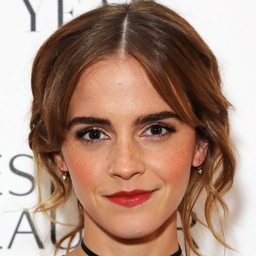

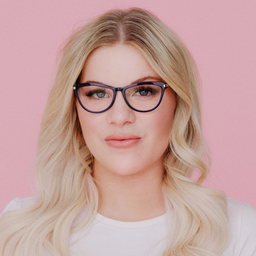

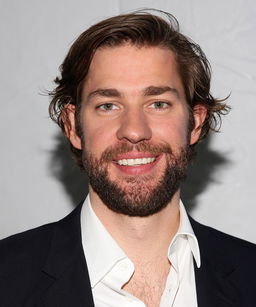

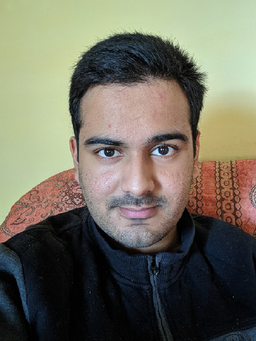

In [0]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

# Auto Allign Images:
## The follwoing script will:


1. Look for faces in the images
2. Crop out the faces from the images
3. Align the faces (center the nose and make the eyes horizontal)
4. Rescale the resulting images and save them in "aligned_images" folder

### The cell below takes about a minute to run


In [0]:
!python align_images.py raw_images/ aligned_images/ --output_size=1048

Using TensorFlow backend.
64045056/64040097 [==============================] - 7s 0us/step
Aligning Me.jpeg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Me_01.png
Aligning Female.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Female_01.png
Aligning John.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/John_01.png
Aligning Emma.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Emma_01.png


## Let us take a look at our alligned images

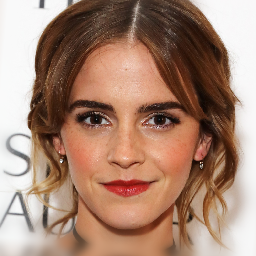

'img 0: Emma_01.png'

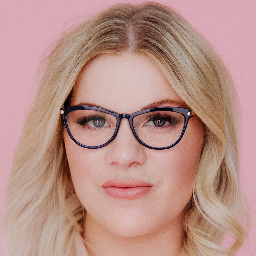

'img 1: Female_01.png'

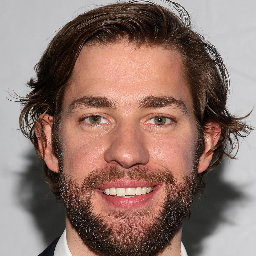

'img 2: John_01.png'

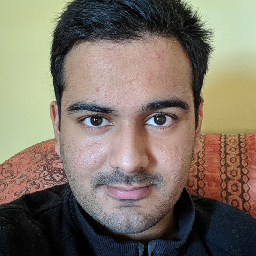

'img 3: Me_01.png'

In [0]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

## Remove any "Bad" images from the "alligned images" folder
## Make sure there aren't too many images, Memory will be used up otherwise(8 at most)

# **Encoding faces into StyleGAN latent space:**

We'll be using pbaylies' awesome encoder repo (building on original work from Puzer): https://github.com/pbaylies/stylegan-encoder

## First, let's download a pretrained resnet encoder: 

--> This model takes an image as input and estimates the corresponding latent code

In [0]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm  -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:02, 129MB/s]


In [0]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))

aligned_images contains 4 images ready for encoding!


# The actual encoding process:

### Note: This script will also download:
*   The pretrained StyleGAN network from NVIDIA trained on faces
*   A pretrained VGG-16 network, trained on ImageNet

### After guessing the initial latent codes using the pretrained ResNet, it will run gradient descent to optimize the latent faces!

### For best performance, set the batch_size argument below equal to the number of aligned_images (see output of previous cell)

### Keep batch_size<8 or the GPU might run out of memory (Colab runs on Tesla K80's)



In [0]:
!python encode_images.py --batch_size=4 --output_video=True --load_resnet='data/finetuned_resnet.h5' --lr=0.01 -decay_rate=0.8 --iterations=200 --use_l1_penalty=0.3 aligned_images/ generated_images/ latent_representations/
print("\n ***************Latent Code Optimization Finished***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







  0% 0/1 [00:00<?, ?it/s]Loading ResNet Model:






  0% 0/200 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:238: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
2019-11-02 15:38:51.230905: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2019-11-02 15:38:52.385740: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. T

# **Loading StyleGAN into Memory:**

In [0]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")







Loading StyleGAN model from cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [0]:
def generate_images(generator, latent_vector, z = True):
  batch_size=latent_vector.shape[0]

  if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
  else: #Start from w: skip the mapping network
    return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)

In [0]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

def generate_images(generator, latent_vector, z = True):
  batch_size=latent_vector.shape[0]

  if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
  else: #Start from w: skip the mapping network
    return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)
def plot_imgs(model,rows,columns):
  for i in range(rows):
    f,axarr = plt.subplots(1,columns,figsize = (20,8))

    for j in range(columns):
      img = generate_images(model, np.random.randn(1,512),z=True)[0]
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Resolution: %s' %str(img.shape))
    plt.show()

## Let us plot some random StyGAN generated images:

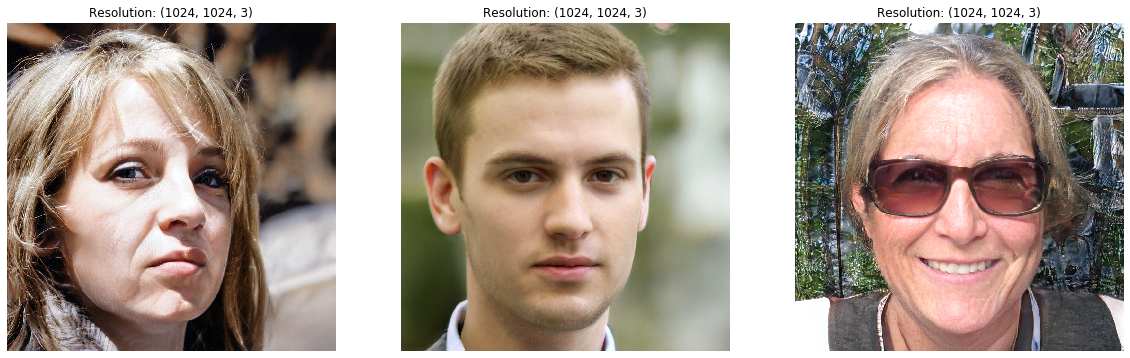

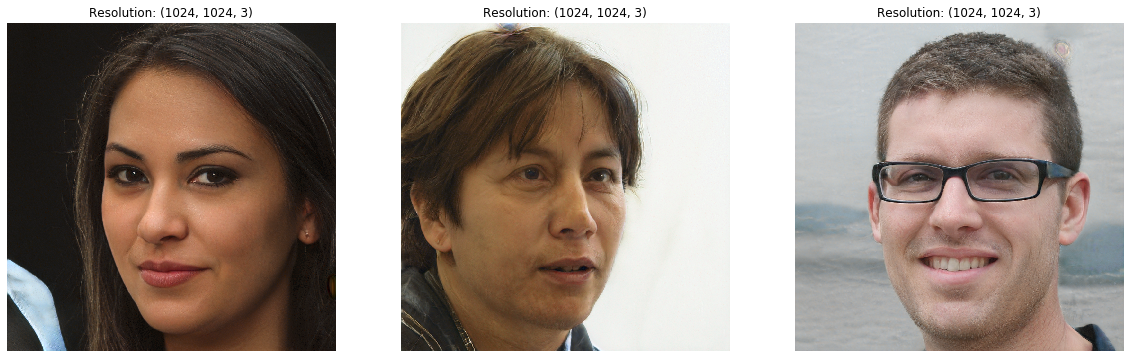

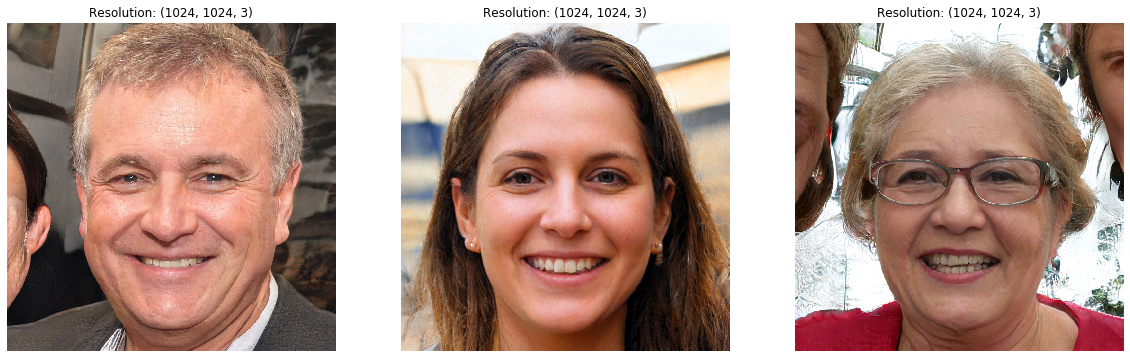

In [0]:
plot_imgs(averaged_generator_network,3,3)

# Let us look at results of our encoding process.

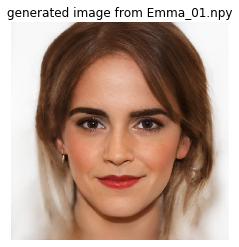

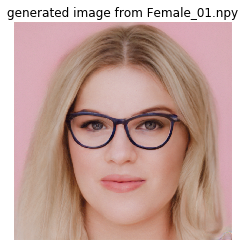

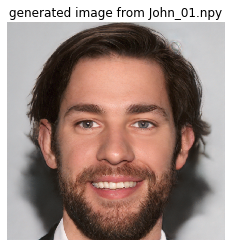

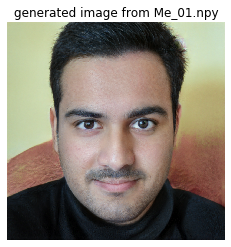

In [0]:
import numpy as np

for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network,w,z=False)[0]
  plt.imshow(img)
  plt.axis('off')
  plt.title('generated image from %s'%f)
  plt.show()

## Let's compare our encoded samples with the original ones:

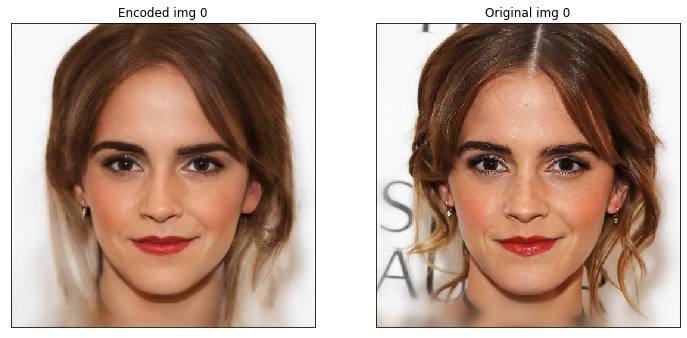

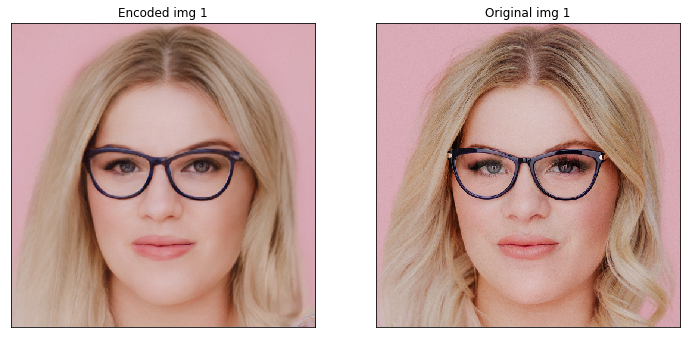

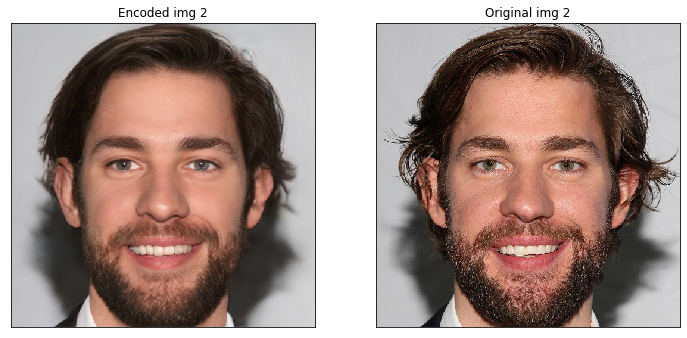

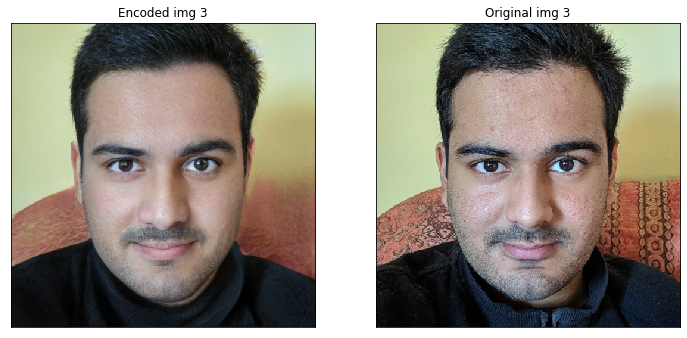

In [0]:
import matplotlib.pyplot as plt

def plot_two_images(img1,img2, img_id, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('Encoded img %d' %img_id)
  axarr[1].imshow(img2)
  axarr[1].title.set_text('Original img %d' %img_id)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i)
    print("")
     
display_sbs('generated_images/', 'aligned_images/', res = 512)

## Cherry pick images & dump their latent vectors to disk
### Manipulating latent vectors (Notebook II) is tricky and will only work well if the face encoding looks 'good'
### Cherry pick a few images where the optimization worked well
(Use the image indices from the plot titles above)

In [0]:
good_images = [0,3]  #Just Taking 2 though all of the obove would be fine

# Saving these latent vectors to disk:

In [0]:
import numpy as np
latents = sorted(os.listdir('latent_representations'))

out_file = '/content/output_vectors.npy'

final_w_vectors = []
for img_id in good_images:
  w = np.load('latent_representations/' + latents[img_id])
  final_w_vectors.append(w)

final_w_vectors = np.array(final_w_vectors)
np.save(out_file, final_w_vectors)
print("%d latent vectors of shape %s saved to %s!" %(len(good_images), str(w.shape), out_file))

2 latent vectors of shape (18, 512) saved to /content/output_vectors.npy!


## Everything we downloaded / saved to disk is currently on a temporary VM running on Google Colab

### (which can be accessed through another notebook you run)
## If you want to reuse the latent vectors later, you can download them manually (highly recommended!!) :


*   Go to the root directory using the Files browser
*   Richt-click & Download the latent representations: "output_vectors.npy"

## Next, let's continue with Part II:
